In [1]:
%config Completer.use_jedi = False

## Why I Wrote This

Fastai inspired me that you can do ML and deep learning yourself, its not and shouldn't be a superpower controlled and dictated by enourmous tech companies in poorly regulated ivory towers for many reasons (See their fantastic courses and in particular [ethics work](https://ethics.fast.ai/) if you're not sure why). Their attitude and demonstration of looking at the big picture, breaking all the components down to understandable bites and then building back up and iterating is a learning pattern that I've found enourmously powerful. I'd like to attempt to do something similar for serving models with MLFLow and Docker, the former helping you track your model work and the latter helping you abstract away your infrastructure; these two tools in conjuction make it fairly straightforward to serve your product at scale with kubernetes and the cloud. Of course this isn't the whole picture and having a total end to end model/product pipeline is the basis of an entire business which I have no business writing about but this should give you a chunk of 'foundations' to lean on and build from.

I also find that a lot of data science folk feel comfortable experimenting and building models but not necessarily tracking their results or serving what they build to a customer. If your products are only ever in development, you're never going to get the proof in the pudding of what you've done in a test environment. There are also a lot of software engineers that are extremely comfortable with the DevOps and CICD/CD (Continuous Integration / Continues Deployment and Continues Delivery. I'm not sure which one is right these days...) part of the equation of serving products but the model work is a mystery, its not a leap for either side of the pond to build the bridge between.

## What I Aim to demonstrate

At a high level I want you to feel comfortable with the following:
 1. Training a Model
 2. Tracking your Experiments & Development Work
 3. Preparing a Model for Serving
 4. Serving a Model
 5. Automating a Majority of the Above Steps
 6. Making Your Work Portable with Docker
 7. Iterating on your Work
 
What I'm not going to explain:
 - The Art of Data Science and Picking Models
 - How to Create an Amazing Customer Experience and Front End
 - State of the Art (SotA) CICD Concepts (Or any SotA for that matter)
 - **Monitoring Your Product**
     - _Now this is a super important topic that I may later come back to and revise as its where you want to spend a lot of attention for machine learning products, data and model drift are real and will end you_
 
## Other Topics of Importance
 - The 'Path to Production'
 - What Tools/Infrastructure we'll need
 - Containers (Briefly)

# What is the "Path to Production"

The "Path to Production" is the series of steps you take from design to having a customer consume what you've built. There's a couple of things of note here, mainly the three mandatory steps of your "Model Experiments" (developing your model), "Model Store" (Build/Serving Artifact), and "Serve the Model to Customer" (Production!). Of course its an entire team with many roles which support and run these kind of flows in an enterprise, there is also an endless amount of depth in each of these topics but at a high level, everyone does these at a minimum. Lets briefly talk about these steps...

## Model Experiments

This is probably where you're spending most of your time and realistically its where value is found. This is where great models and answers are discovered, no point going to production if you haven't got a solution to something! Now this workflow could be simply jupyter notebooks on your laptop pointing to a static dataset, you might have a totally cloud driven data lake and data science toolbench with a cloud provider. Regardless, this is where you're developing your solution to the problem at hand and once you're satisfied with your solution, you want to take this to the customer to help them.

I'm going to briefly touch on 'data pipelines' and 'feature stores' as they are becoming more common terms and its worth a brief discussion but don't feel like they're something you have to build in a standard and beautiful way to start, you can iterate your way to brilliance but start without them if they're unfamiliar.

### Data Pipeline

Data pipelines are 'pipes' for data to transform them from their raw source to something useful and usable. Commonly they are defined as DAGs within common distributed processing libraries such as spark but most data science libraries have their own tools to do pipelining (pytorch, tensorflow to name a couple examples). In most production scenarios you're getting some signal from somewhere, maybe a constant stream of trades happening on the stock exchange or an hourly batch of transactions happening between customers and your business. Its unlikely that the raw data is in the kind of format you'll want to work with and its likely some basic enrichments will transform the data into a valuable input for your modelling workflow. This might something simple like aggregations for a particular customer over time, or a cumulative sum of sales for the day etc, conversion of data types or whatever features are useful for your modelling problem.

### Feature Store

[Phdata](https://www.phdata.io/blog/what-is-a-feature-store/) has a lovely introduction to feature stores which I recommend reading. Following on from data pipelines above, feature stores allow you to share features which may be commonly used which gives you a few obvious benefits:
 - Reduce duplication of work | For example everyone should calculate cumulative sales for the day, the same way
 - Reduce compute | If a particular feature is expensive to solve for, you can compute it once and share the results
 - Iterate and Improve on features | Once you've developed a good signal / feature, may as well version it and iterate on it for others rather than re-inventing it again and again
 
I find it useful to think of feature stores as a type of 'feature pipeline', of course these features are derived from the available data in your data pipelines but its about sharing great work in transformations and standardising definitions for your business. You want to make sure that everyone defines core features the same way or at least have some way of comparing how you've developed a feature in comparison to another version or another feature.

## Model Store

Model stores are where you keep the models you've built, often to rank and compare models to each other. This is especially helpful when your running lots of experiments and in a regimented way want to store your progress and work as well as compare under what conditions you produced your best (and worst) solutions (models). It also serves a purpose similar to build artifact stores in classical software development as often the "product" you're serving is actually your model that you plug in to other interfaces (website front end, serving api etc) instead of a built application.

## Serve the Model to Customer

This is where you provide an interface to your model for your customer, often this is a server providing an API which would be called by your consuming service. This might be a front-end website making predictions for a particular customer or your trading software calling for whether to buy or sell a particular stock ticker. In my example we're going to use MLFlow but of course there's a zillion (I've measured, I promise its in the zillions) services out there to use, MLFlow is fairly straightforward and is open-source so no nasty barriers to use it!

# Path to Production Visualised

*Orange is mandatory, Blue is optional somewhat*

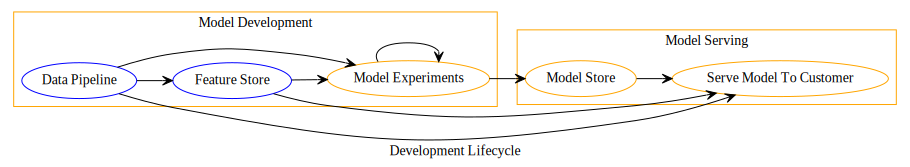

In [2]:
import graphviz

dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'LR'
dot.graph_attr["label"] = "Development Lifecycle"
dot.edge_attr.update(arrowhead='vee', arrowsize='1')

dot.node('A', 'Model Experiments',color="Orange",rankdir="LR")
dot.node('B', 'Model Store',color="Orange")
dot.node('C', 'Serve Model To Customer',color="Orange")
dot.node("D","Data Pipeline",color="Blue")
dot.node("E","Feature Store",color="Blue")

with dot.subgraph(name='cluster_1') as c:
    c.attr(color='Orange')
    c.node_attr['style'] = 'filled'
    c.edges([("B",'C'),('A', 'B')])
    c.attr(label='Model Serving')

with dot.subgraph(name='cluster_2') as c:
    c.attr(color='orange')
    c.node_attr['style'] = 'filled'
    c.edges([('D',"A"),("D","E"),("A","A"),("E","A")])
    c.attr(label='Model Development')
    
dot.edges([("D","C"),("E","C")])

dot

# What Infrastructure Do We Need?

Now we need to think about the kind of computers/infrastructure we need to rely on, there are a few services we require.

## CICD (Continuous Integration Continuous Deployment) / Orchestrator

Sometimes referred to as Continuous Delivery (CD), your CD tool is the engine that will automate the build & deploy process we have for our models, again this can grow to many levels of complexity, especially when considering deployment strategies and rollbacks, model and data drift once deployed which might cause you to change deployments/models, up-time/down-time for your services during deployment etc.

The important thing is that the CICD tool helps you run all of the packing and shipping steps as an automated and easy to replicate process, we will use Jenkins in our example as its open source and fairly easy but there's lots of popular tools waiting out there for you and they all have different flavours and benefits

## Data Platform

This is where we store our data, in this example its just our C: drive! Of course you might have a distributed data lake on the cloud with lots of parallel processing or a sqlite DB you're reading from or whatever. Regardless you have somewhere to access the data you require for modelling and this may or may not include data pipelines and a feature store which we touched on earlier.

## Dev Environment / Notebook

This is where we run our experiments and develop our models, again this might be jupyterlab on your laptop or AzureML studio etc, the important bit is you have somewhere to experiment and build your model or solution for the customer.

## Docker

This is what we will use in our example to segregate our services and make our application fairly portable. We can move these 'containers' to any kind of infrastructure that can run Docker (Docker runs pretty much everywhere), you can set all this up on your laptop and then move the whole set of Docker services to the cloud to scale when you need.

### What is a Container

[From Docker themselves](https://www.docker.com/resources/what-container), please head to the "Comparing Containers and Virtual Machines" title. This gives a nice and succint description of why this is important


## Visualisation of Infra Over Our Workflow from Above
**Red is our infrastructure / computers that we rely on**

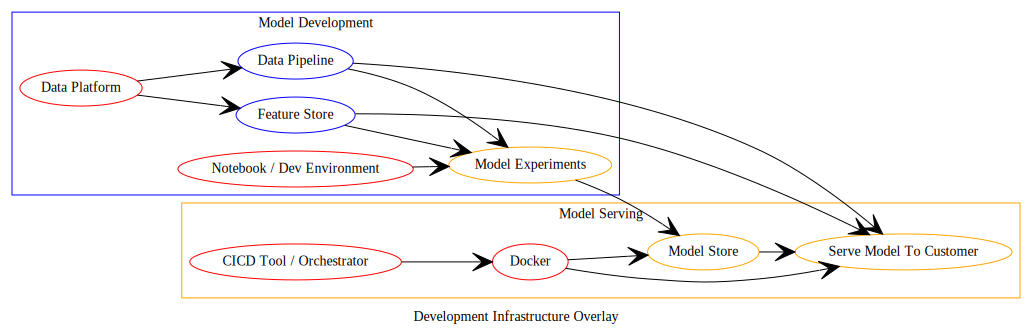

In [3]:
import graphviz

dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'LR'
dot.graph_attr["label"] = "Development Infrastructure Overlay"
dot.edge_attr.update(arrowhead='vee', arrowsize='2')

dot.node('A', 'Model Experiments',color="Orange",rankdir="LR")
dot.node('B', 'Model Store',color="Orange")
dot.node('C', 'Serve Model To Customer',color="Orange")
dot.node("D","Data Pipeline",color="Blue")
dot.node("E","Feature Store",color="Blue")

dot.node("F","Docker",color="red")
dot.node("G","CICD Tool / Orchestrator",color="red")
dot.node("I","Notebook / Dev Environment",color="red")
dot.node("J","Data Platform",color="red")


with dot.subgraph(name='cluster_1') as c:
    c.attr(color='Orange')
    c.node_attr['style'] = 'filled'
    c.edges([("B",'C'),("F","C"),("F","B"),("G","F")])
    c.attr(label='Model Serving')

with dot.subgraph(name='cluster_2') as c:
    c.attr(color='blue')
    c.node_attr['style'] = 'filled'
    c.edges([('D',"A"),("E","A"),("I","A"),("J","D"),("J","E"),('A', 'B')])
    c.attr(label='Model Development')

dot.edges([("D","C"),("E","C")])
    
dot

# 1. Training a Model

Before we get started, we've gotta get an MLFlow server running to throw our models to etc:

In a terminal run the following, clearly replace my artifact location of `C:\Users\Nick\Documents\Github\blog\artifacts` with where you'd like to locally store your artifacts, we will change these later with Docker:

```
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root C:\Users\Nick\Documents\Github\blog\artifacts --host 0.0.0.0
```

# Grab Some Data to Build a Model

I've grabbed the source code from MLFlow tutorial example which uses the wine ratings dataset from the University of California's open ML dataset database. This is a good place to start and discuss the steps we need to go from development to serving.

Note I've put in comments within the code to discuss the importance...

In [4]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

import mlflow
import mlflow.sklearn

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

# Here's the tracking URI we setup in the prior cell, this makes sure our mlflow API points to the right server etc.
mlflow.set_tracking_uri("http://localhost:5000")

# Using the wine quality sample and training code from the MLFLow tutorial (https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html)
def train(in_alpha, in_l1_ratio,model_name):
    
#   This is a simple method to spitout some evaluation metrics which we can use to compare models
    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2


    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Read the wine-quality csv file from the URL
    csv_url =\
        'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(csv_url, sep=';')
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e)

    # Split the data into training and test sets. (0.75, 0.25) split.
    train, test = train_test_split(data)

    # The predicted column is "quality" which is a scalar from [3, 9]
    train_x = train.drop(["quality"], axis=1)
    test_x = test.drop(["quality"], axis=1)
    train_y = train[["quality"]]
    test_y = test[["quality"]]

    # Set default values if no alpha is provided
    if float(in_alpha) is None:
        alpha = 0.5
    else:
        alpha = float(in_alpha)

    # Set default values if no l1_ratio is provided
    if float(in_l1_ratio) is None:
        l1_ratio = 0.5
    else:
        l1_ratio = float(in_l1_ratio)

    # Useful for multiple runs (only doing one run in this sample notebook)    
    with mlflow.start_run():
        # Execute ElasticNet from sklearn and fit the model
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        # Evaluate Metrics with our lovely eval metrics method from before
        predicted_qualities = lr.predict(test_x)
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        # Print out metrics
        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        
        # Register the model in MLFlow for later use and comparison
        mlflow.sklearn.log_model(lr, "model", registered_model_name=model_name)

# 2. Tracking Your Experiments

Our awesome train method will now download our data, build a model, fit it to the data, evaluate the model and register it with MLFlow to later compare.

Lets run a few iterations with different hyper-parameters to see how it better fits the data we have. Of course this is a terrible technique to select your hyper-parameters but I'm walking through building and serving a model rather than a deep talk about hyper-parameter choices.

In [9]:
train(0.5, 0.5,"Wine_5")
train(0.1, 0.1,"Wine_1")
train(0.9, 0.9,"Wine_9")

Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 0.7931640229276851
  MAE: 0.6271946374319587
  R2: 0.10862644997792614


Successfully registered model 'Wine_5'.
2022/12/23 17:55:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Wine_5, version 1
Created version '1' of model 'Wine_5'.


Elasticnet model (alpha=0.100000, l1_ratio=0.100000):
  RMSE: 0.7128829045893679
  MAE: 0.5462202174984665
  R2: 0.2799376066653344


Successfully registered model 'Wine_1'.
2022/12/23 17:55:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Wine_1, version 1
Created version '1' of model 'Wine_1'.


Elasticnet model (alpha=0.900000, l1_ratio=0.900000):
  RMSE: 0.8329464950658837
  MAE: 0.6710843636018047
  R2: 0.01696735695860563


Successfully registered model 'Wine_9'.
2022/12/23 17:55:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Wine_9, version 1
Created version '1' of model 'Wine_9'.


## Experiment Tracking Page of MLFlow

Lovely! A bunch of trained models & they're registered, lets checkout MLFlow on our server we setup a moment ago and see how we went. We could have of course registered these all as different versions of the same model, I've simply separated them for visual ease.

*Visit "127.0.0.1:5000" in another tab if you're running this locally to see your models registered and to compare them*

Below we can see my example and there's a few key things to note:

 - All our runs/experiments were tracked and we can see how long they took and who ran them
 - We can see metrics to measure how good the models were
 - We can see what (hyper) parameters were used
 - We can see the model names stored
 
Of course there's much more we can do with MLFlow but for not much code this is a lot of bang for your buck, you can track and see all your inputs and outputs as well as your progress for the problem you're trying to solve based on the metrics and targets you set out.

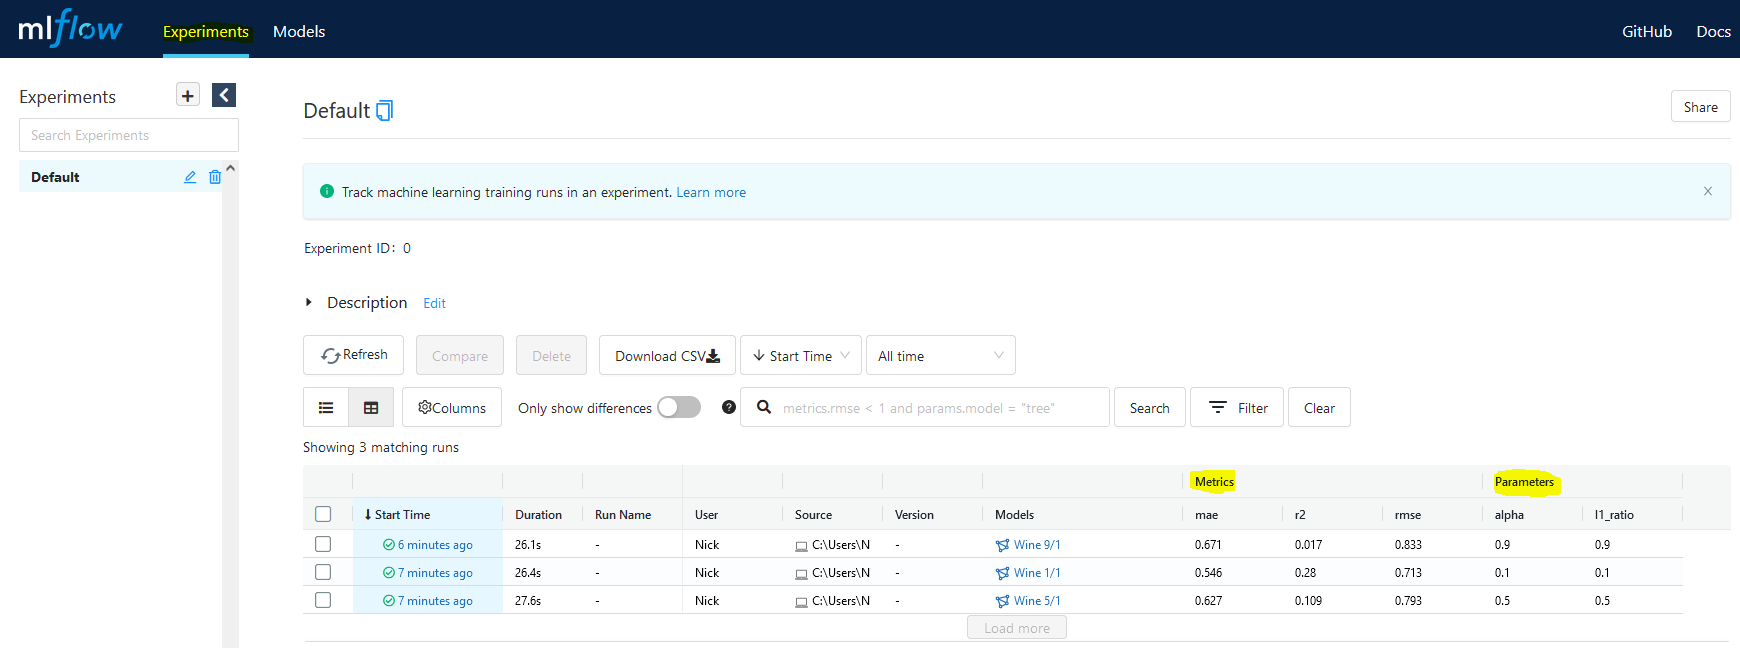

In [20]:
from IPython.display import Image
Image(filename='./images/Experiment Window.PNG') 

## Model Store Page

Lets look at MLFlows "Registered Models" page where we can see all the models we have built, which version and what stage they're at.

Again think about the bang for buck here, with very few lines we can track and trace all out models and how well they did, where they went and how they're being used. Two things of note, firstly the staging column and the production column, this are two stages (although you can define more) which are often used as you'd often want to run a model in parallel in staging against a model in production to compare if its outperforming what you're currently serving to customers. Now you can investigate further into each experiment and each model, see what weights were finalised and where the actual model artifacts and pickles are stored + other metadata. We don't have to get too bogged down for now, we have now got a few models, of which we can pick one to serve.

We now have our three models that we trained, from the experiments page, in particular it looks like "Wine 9" did the best. Lets now set this up for production and serve it to a (potential) customer!

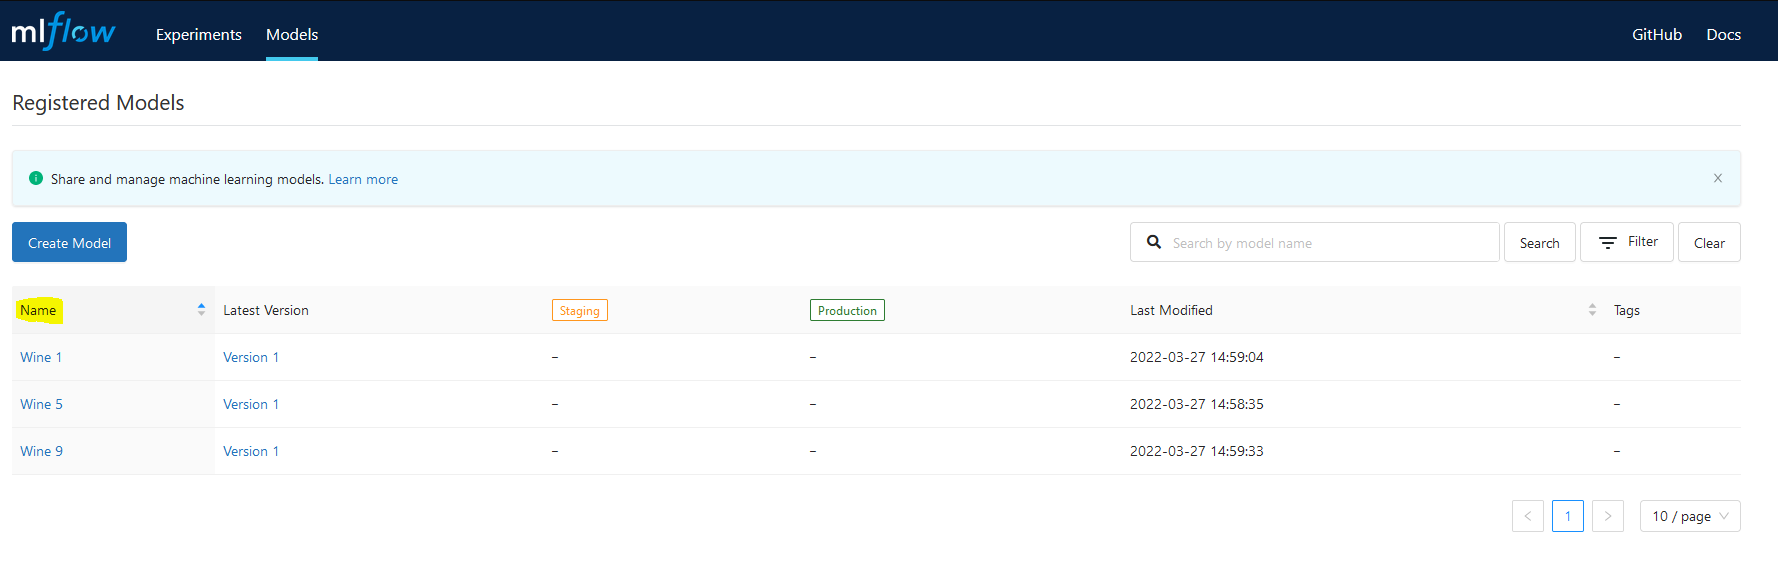

In [15]:
from IPython.display import Image
Image(filename='./images/Model Store Window.PNG') 

## Retrieving a Model & Predicting

Now that you've registered and have stored a model with weights, I'll quickly show you how to retrieve that model and make a prediction. It should feel accessible like a "store", hence the name.

In [23]:
import mlflow.pyfunc

# Our Model Params
model_name = "Wine_9"
model_version = 1

# Instantiate the Model
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

# Read some data & make a prediction
data = pd.read_csv("../data/wine/winequality-red.csv",sep=";")
model.predict(data.drop("quality",axis=1).head(1))

array([5.66884999])

# 3. Preparing a Model for Production/Serving

Ok now that we've got our models prepped and ready to go, lets move our "Wine 9" model from development to "Production" so we know this is being served and used. Of course if we had more things we wanted to do as preparation we can perform these steps as well but for now we just want to register it as "Production" and we'll go serve it in the next step.

In [24]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
client.transition_model_version_stage(
    name="Wine_9",
    version=1,
    stage="Production"
)

<ModelVersion: creation_timestamp=1671778522400, current_stage='Production', description='', last_updated_timestamp=1671778783281, name='Wine_9', run_id='f1b7536305b94d9f92676d7bb0ca09e6', run_link='', source='mlflow-artifacts:/0/f1b7536305b94d9f92676d7bb0ca09e6/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

# 4. Serving a Model
Run the following to serve your model with access to the artifacts location, I've changed the port to not conflict with our MLFLow UI Server, also note my GUID will be different from yours...
```
mlflow models serve -m "./artifacts/0/6984dd63172e4c928472fb9d23c74d7f/artifacts/Wine_9" -p 5001
```

We can now make some predictions against the model that we are now serving at this web address via the model serve api mlflow provides.

In [2]:
import requests
import pandas as pd

data = pd.read_csv("../data/wine/winequality-red.csv",sep=";")
predict = data.drop("quality",axis=1).head(3)
predict

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


The above is the data we want to use for the prediction which I've just grabbed from the input dataset but in production this would be the customer request you have incoming.

Let send a few rows and get back some predictions...

In [3]:
x = requests.post("http://127.0.0.1:5001/invocations",
                  headers={"Content-Type":"application/json","format":"pandas-split"},
                  data=predict.to_json(orient="split"))
x.json()

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5001): Max retries exceeded with url: /invocations (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000027600004CD0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

## Customers Can Consume!
We did it! We can now consume the model we trained.

Now there's a bunch thats janky about this:
 - We've had to grab the guid for the path object of our model
 - Its all Manual
 - Our training Process is Naive
 - Its all running on a single computer and isn't portable
 - Many more issues
 
But I think we should be really happy to go from not having an obvious way to serve a customer our models to a totally consumable REST API which we could build ontop of with a website or anything else we'd like.

More to come....

# 5. Automating and Orchestrating A Chunk of the Above!

The following I will update in the future once I revisit this blog 😀, please contact me if I've got lazy!

# 6. Docker-ifying Our World

# Using the MLFlow Client to Investigate Models

# Feature Store Example

# Data Pipelines Example